In [ ]:
#**********************************************************************************************************
#                OVERVIEW
#
# Project:       Scope 3 Emissions Dashboard
#
# Program Name:  w1c_obtain_make_model_age_class_type.ipynb
#
# Summary:       Obtaining Make / Model / Age / Vehicle Class / Vehicle Type info via the Optifleet VEEEL
#                and NZTA APIs
#
# Details:       In this program we obtain Make / Model / Age / Vehicle Class / Vehicle Type info for all
#                required vehicles. This is achieved according to the following process:
#                   a) Look up information from the VIN library
#                   b) Where this fails fetch data from the VEEEL API  (FREE)
#                   c) Where this fails fetch data from the NZTA API   ($0.16 per call)
#                This information is then added to the VIN library to prevent us having to call the APIs
#                again in the future for the same vehciels.
#
# Details:       Section 0:
#                Import required python packages, define API credentials and functions and read in the 
#                data set produced in the previous program
#
#                # Section 1:
#                Attempt to look up Vehicle Class, Vehicle Type, Make, Model & Year info from the VIN library
#
#                Section 2:
#                Construct the necessary definitions and helpers to call data from the VEEEL and NZTA APIs
#
#                Section 3:
#                Call data from the VEEEL API and process
#
#                Section 4:
#                Identify vehicles for which the VEEEL Api didn't return results and fetch from the NZTA Api instead
#
#                Section 5:
#                Append the vee1d and nzt1e data frames, deal with missing variables and map to vehicle class and type
#
#                Section 6:
#                Create final data set
#
#                Section 7:
#                Create summary counts of missing values
#
#                Section 8:
#                Append the new results to the vin library
#
#                Section X:
#                Export Temporary CSV Outputs
#
#                Section Z:
#                Send automatic email specifying cost of API calls
 
#**********************************************************************************************************
#                DEPENDENCIES AND LIMITATIONS

# Input(s):      zzz_api_Output_df2
#                1. bodystyle to vehicle type mapping.csv

# Output(s):     zzz_api_Output_df3

# Dependencies:  NA

# Limitations:   NA




SCHEMATIC OF PROCESS

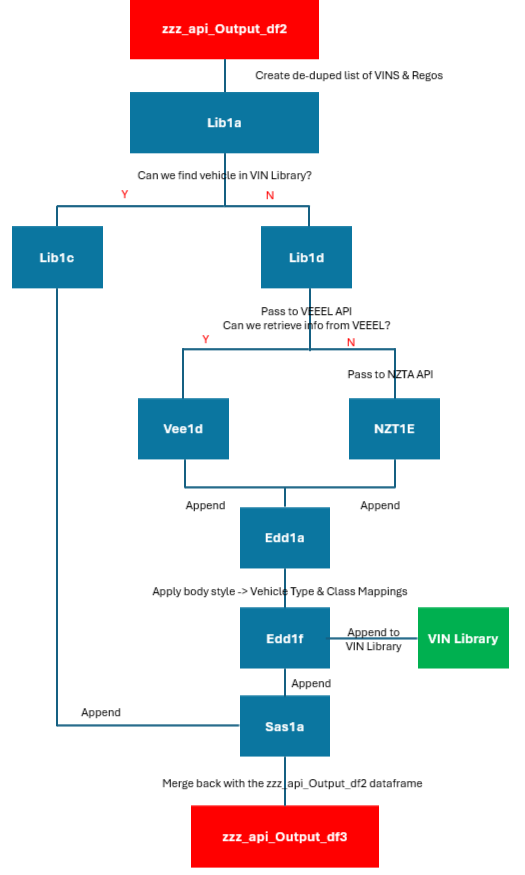

In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 0:
# Import required python packages, define API credentials and functions and read in the data set produced 
# in the previous program
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 0.1a - Load packages, libraries, parameters and api credentials from the shell script
%run -i w0_scope3_emissions_shell_script.ipynb


In [ ]:
# 0.1b - Read in the output data set from the previous program 
zzz_api_Output_df2 = pd.read_csv(out_folder+'zzz_api_Output_df2.csv')

# ----------------
# Show output
zzz_api_Output_df2


In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 1:
# Attempt to look up Vehicle Class, Vehicle Type, Make, Model, Year & cc_rating info from the VIN library
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 1.1a - Refine the previous data set to required variables
lib1a = zzz_api_Output_df2.copy()
lib1a = lib1a[["vin", "registration_plate"]]
lib1a = lib1a.drop_duplicates()

# !!! WARNING THIS IS NOT THE SAME ROW_ID AS IN THE zzz_api_Output_df2 DATAFRAME !!!
lib1a['row_id'] = range(1, len(lib1a) + 1)
lib1a = lib1a[["row_id", "vin", "registration_plate"]]
lib1a = lib1a.reset_index(drop=True)


# ----------------
# Show output
# lib1a


In [ ]:
# 1.1b - Merge on the data from the vin library 

# Read in the vin_library.csv data set
lib1b = pd.read_csv(vin_lib+'vin_library.csv')

# Fliter to the LAST instance of each vin (just in case there are duplicates)
lib1b = lib1b.drop_duplicates(subset='vin', keep='last')
lib1b = pd.merge(lib1a, lib1b, how='left', left_on=["vin"], right_on=["vin"])


# ----------------
# Show output
# lib1b


In [ ]:
# 1.1c - Identify which vehicles HAVE been matched
lib1c = lib1b.copy()
lib1c = lib1c[lib1c['vehicle_class'].notna()]

# ----------------
# Show output
print("Number of vehicles that have been matched:", len(lib1c))
# lib1c


In [ ]:
# 1.1d - Identify which vehicles HAVE NOT been matched

lib1d = lib1b.copy()
lib1d = lib1d[lib1d['vehicle_class'].isna()]
lib1d = lib1d[["row_id", "vin", "registration_plate"]]

# ----------------
# Show output
print("Number of vehicles that need to be passed to the VEEEL Api:", len(lib1d))
# lib1d



In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 2:
# Construct the necessary definitions and helpers to call data from the VEEEL and NZTA APIs
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# Set up API Base, Credentials and Networking Options

# API base URLs
BESTCAR_BASE = "https://data.bestcar.co.nz/api/v1"
AUTH_URL     = f"{BESTCAR_BASE}/Connect/Authorize"
VEHICLE_URL  = f"{BESTCAR_BASE}/rawdata/vehicle"

# Credentials
APP_KEY    = appKey
APP_SECRET = appSecret

# Networking options
TIMEOUT_SECS = 30
PAUSE_BETWEEN_CALLS = 0.1


In [ ]:
# Construct Resilient HTTP session + API client (updated to read 'bearer' token)

def _session_with_retries() -> requests.Session:
    s = requests.Session()
    retry = Retry(
        total=6,
        backoff_factor=0.6,                 # 0.6, 1.2, 2.4, ...
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=("GET", "POST"),
        raise_on_status=False,
    )
    adapter = HTTPAdapter(max_retries=retry, pool_connections=10, pool_maxsize=10)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s


class BestCarClient:
    def __init__(self, app_key: str, app_secret: str):
        self.app_key = app_key
        self.app_secret = app_secret
        self.session = _session_with_retries()
        self._bearer: Optional[str] = None

    def authorize(self) -> str:
        """
        Authorize and cache a bearer token. Your API returns the field 'bearer'.
        """
        params = {"appKey": self.app_key, "appSecret": self.app_secret}
        r = self.session.get(AUTH_URL, params=params, timeout=TIMEOUT_SECS)
        if r.status_code != 200:
            raise RuntimeError(f"Auth failed ({r.status_code}): {r.text[:200]}")

        data = r.json()
        # Accept several common field names; BestCar currently uses 'bearer'
        token = (
            data.get("bearer")
            or data.get("token")
            or data.get("access_token")
            or data.get("Token")
            or data.get("AccessToken")
        )
        if not token:
            # Fallback: pick a JWT-looking string (xxx.yyy.zzz) if present
            for v in data.values():
                if isinstance(v, str) and v.count(".") == 2:
                    token = v
                    break
        if not token:
            raise RuntimeError(f"Auth succeeded but no token field found: {data}")

        self._bearer = token
        return token

    @property
    def headers(self) -> Dict[str, str]:
        if not self._bearer:
            self.authorize()
        return {
            "Authorization": f"Bearer {self._bearer}",
            "Accept": "application/json",
        }

    def get_vehicle(self, plate_or_vin: str, query_source: int) -> Tuple[int, Dict[str, Any]]:
        """
        Call /rawdata/vehicle for one VIN/plate and one source.
        Returns (status_code, json_dict or {"_error": "..."}).
        """
        params = {"plateVin": plate_or_vin, "querySource": query_source}
        try:
            r = self.session.get(VEHICLE_URL, headers=self.headers, params=params, timeout=TIMEOUT_SECS)
            # 401 might mean token expired; try one silent re-auth
            if r.status_code == 401:
                self.authorize()
                r = self.session.get(VEHICLE_URL, headers=self.headers, params=params, timeout=TIMEOUT_SECS)

            status = r.status_code
            if status == 200:
                try:
                    return status, r.json()
                except Exception:
                    return status, {"_error": "Invalid JSON", "_raw": r.text[:500]}
            else:
                return status, {"_error": f"HTTP {status}", "_raw": r.text[:500]}
        except requests.RequestException as e:
            return 0, {"_error": f"RequestException: {e}"}

        

In [ ]:
# Construct helpers to prep VIN, test success, fetch and flatten the data

def clean_vins(df: pd.DataFrame, vin_col: str = "vin") -> list[str]:
    if vin_col not in df.columns:
        raise KeyError(f"Expected column '{vin_col}' in DataFrame.")
    vins = (
        df[vin_col]
        .astype(str)
        .str.strip()
        .replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        .dropna()
        .drop_duplicates()
        .tolist()
        )
    return vins


def is_success(status_code: int, payload: Dict[str, Any]) -> bool:
    """
    Define what counts as 'obtained information'.
    Here: HTTP 200 + payload is a non-empty dict without an _error flag.
    If the API wraps data under e.g. 'data' key, you can tighten this to: bool(payload.get('data')).
    """
    if status_code != 200:
        return False
    if not isinstance(payload, dict) or not payload:
        return False
    if "_error" in payload:
        return False
    return True


def _flatten_with_prefix(payload_obj, prefix: str) -> dict:
    """
    Accepts dict OR list. For list:
      - []          -> {prefix__empty_list: True}
      - [ {…} ]     -> flatten the first element
      - [ {…},{…} ] -> flatten each with index: prefix__0__field, prefix__1__field, …
    Also accepts stringified JSON and attempts json.loads on it.
    """
    # If payload is string, try to parse as JSON
    if isinstance(payload_obj, str):
        try:
            payload_obj = json.loads(payload_obj)
        except Exception:
            # Just return the raw string if not JSON
            return {f"{prefix}__raw": payload_obj}

    if isinstance(payload_obj, dict):
        flat = pd.json_normalize(payload_obj, sep="__")
        return {f"{prefix}__{k}": v for k, v in ({} if flat.empty else flat.iloc[0].to_dict()).items()}

    if isinstance(payload_obj, list):
        if len(payload_obj) == 0:
            return {f"{prefix}__empty_list": True}
        if len(payload_obj) == 1 and isinstance(payload_obj[0], dict):
            flat = pd.json_normalize(payload_obj[0], sep="__")
            return {f"{prefix}__{k}": v for k, v in ({} if flat.empty else flat.iloc[0].to_dict()).items()}
        # multiple rows -> index the keys
        out = {}
        for i, item in enumerate(payload_obj):
            if isinstance(item, dict):
                flat = pd.json_normalize(item, sep="__")
                d = {} if flat.empty else flat.iloc[0].to_dict()
                out.update({f"{prefix}__{i}__{k}": v for k, v in d.items()})
            else:
                out[f"{prefix}__{i}__value"] = item
        return out

    # Fallback for other types
    return {f"{prefix}__unsupported_type": type(payload_obj).__name__}


def fetch_source_for_vins(
    client: BestCarClient,
    vins: Iterable[str],
    query_source: int,
    prefix: str,
    pause: float = PAUSE_BETWEEN_CALLS,
) -> pd.DataFrame:
    rows = []
    for v in vins:
        status, payload = client.get_vehicle(v, query_source=query_source)
        row = {"vin": v, f"{prefix}__status_code": status}
        # Flatten dict/list/string payloads
        row.update(_flatten_with_prefix(payload, prefix))
        rows.append(row)
        if pause:
            time.sleep(pause)
    return pd.DataFrame(rows)



In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 3:
# Call data from the VEEEL API and process
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 3.1a - Check that we have authorized access to the BestCar App
client = BestCarClient(APP_KEY, APP_SECRET)
client.authorize()

# ----------------
# Show output
print("Authorized ✓")


In [ ]:
# 3.1b - Apply the 'clean_vins' function to the lib1d dataframe and print the number of VINs to query
vin_col = "vin"
vins_all = clean_vins(lib1d, vin_col=vin_col)

# de-dup if necessary
vins_all = list(dict.fromkeys(vins_all))

# ----------------
# Show output
# vins_all

In [ ]:
# 3.1c - Call the VEEEL API and retrieve as many vehicles as possible

# Start timer
start = time.time()

# Call the VEEEL API
if vins_all:
    vee1c = fetch_source_for_vins(client, vins_all, query_source=0, prefix="VEEEL")
    print(f"VEEEL calls completed: {len(vee1c)} rows")
else:
    vee1c = pd.DataFrame(columns=["vin", 
               "VEEEL__vehicle__Make", "VEEEL__vehicle__Model", 
               "VEEEL__vehicle__mvrYear", "VEEEL__vehicle__VehicleType", 
               "VEEEL__vehicle__Doors", "VEEEL__vehicle__Seats", "VEEEL__vehicle__Weight", "VEEEL__vehicle__FuelType",  
               "VEEEL__vehicle__EngineSize"])
    
# Show time taken to return fetch data from the API
result = sum(range(10_000_000))
end = time.time()
print(f"Execution time: {end - start:.4f} seconds")

# ----------------
# Show output
# vee1c


In [ ]:
# 3.1d - Refine to the required fields (fields may not always exist as previous dataframe extracted from API)

vee1d = vee1c.copy()

# Desired schema: variable name and target dtype
desired_columns = {
    "vin": "string",
    "VEEEL__vehicle__Make": "string",
    "VEEEL__vehicle__Model": "string",
    "VEEEL__vehicle__mvrYear": "float64",       # numeric
    "VEEEL__vehicle__VehicleType": "string",
    "VEEEL__vehicle__Doors": "float64",         # numeric
    "VEEEL__vehicle__Seats": "float64",         # numeric
    "VEEEL__vehicle__Weight": "float64",        # numeric
    "VEEEL__vehicle__FuelType": "string",
    "VEEEL__vehicle__EngineSize": "float64",    # numeric
}

# Ensure all required columns exist
for col, dtype in desired_columns.items():
    if col not in vee1d.columns:
        vee1d[col] = np.nan

# Subset and cast to the correct dtypes
vee1d = vee1d[list(desired_columns.keys())].astype(desired_columns)


vee1d = vee1d.rename(columns={'VEEEL__vehicle__Make': 'make', 
                              'VEEEL__vehicle__Model': 'model', 
                              'VEEEL__vehicle__mvrYear': 'year', 
                              'VEEEL__vehicle__VehicleType': 'bodystyle', 
                              'VEEEL__vehicle__Doors': 'doors',
                              'VEEEL__vehicle__Seats': 'seats',
                              'VEEEL__vehicle__Weight': 'weight', 
                              'VEEEL__vehicle__FuelType': 'fueltype', 
                              'VEEEL__vehicle__EngineSize': 'cc_rating'})


# Merge row_id information back in
extra_df = lib1d[['row_id', 'vin', 'registration_plate']]
vee1d = pd.merge(extra_df, vee1d, how='right', left_on=["vin"], right_on=["vin"])
vee1d = vee1d[vee1d['make'].notna()]

# ----------------
# Show output
# vee1d


In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 4:
# Identify vehicles for which the VEEEL Api didn't return results and fetch from the NZTA Api instead
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 4.1a - Identify which vehicles we have not obtained data for and which need to be passed to the NZTA API

nzt1a = vee1d.copy()
nzt1a = nzt1a[["row_id"]]
nzt1a['veeel_returned'] = 1
nzt1a = pd.merge(lib1d, nzt1a, how='left', left_on=["row_id"], right_on=["row_id"])
nzt1a['veeel_returned'] = nzt1a['veeel_returned'].fillna(0)
nzt1a = nzt1a[nzt1a['veeel_returned'] == 0]
nzt1a = nzt1a[["row_id", "vin", "registration_plate"]]

# ----------------
# Show output
print("Number of vehicles that need to be passed to the NZTA Api:", len(nzt1a))
# nzt1a


In [ ]:
# !!!   Add in a stopping procedure if the number of NZTA Api calls will exceed the limit (max_nzta_calls)   !!!

if len(nzt1a) > max_nzta_calls:
    raise SystemExit("Warning: Number of NZTA calls exceeds the specified limit")
else:
        print("Number of API calls is less than or equal to the specified limit")

In [ ]:
# 4.1b - It appears that the NZTA Api works on registration plate as opposed to VIN. 
# Here we decide what (de-duped) registration plates to send to the api

if not nzt1a.empty:
    nzt1b = (
        nzt1a['registration_plate']
        .dropna()
        .astype(str)
        .str.strip()
        .unique()
        .tolist()
    )
else:
    nzt1b = []

# ----------------
# Show output
# nzt1b


In [ ]:
# 4.1c - Call the NZTA API if we have plates to process

if nzt1b:
    nzt1c = fetch_source_for_vins(
        client,
        nzt1b,
        query_source=1,
        prefix="NZTA"
    )
else:
    nzt1c = pd.DataFrame(columns=['vin', 'NZTA__nztaVehicle__VIN', 
               'NZTA__nztaVehicle__Make', 'NZTA__nztaVehicle__Model',
               'NZTA__nztaVehicle__YearOfManufacture', 'NZTA__nztaVehicle__BodyStyle', 
               'NZTA__nztaVehicle__NumberOfSeats', 'NZTA__nztaVehicle__GrossVehicleMass', 'NZTA__nztaVehicle__FuelType', 
               'NZTA__nztaVehicle__CCRating'])
    
# ----------------
# Show output
# nzt1c


In [ ]:
# 4.1c1 - Error handling in the case whereby every VIN lookup fails

nzt1c1 = nzt1c.copy()

if not nzt1c1.empty and (nzt1c1['NZTA__success'] == False).all():
    nzt1c1 = pd.DataFrame(columns=[
        'vin', 
        'NZTA__nztaVehicle__VIN', 
        'NZTA__nztaVehicle__Make', 
        'NZTA__nztaVehicle__Model',
        'NZTA__nztaVehicle__YearOfManufacture', 
        'NZTA__nztaVehicle__BodyStyle', 
        'NZTA__nztaVehicle__NumberOfSeats', 
        'NZTA__nztaVehicle__GrossVehicleMass',
        'NZTA__nztaVehicle__FuelType',
        'NZTA__nztaVehicle__CCRating'
    ])
    
# ----------------
# Show output
# nzt1c1

In [ ]:
# 4.1d - Refine to required variables 

nzt1d = nzt1c1.copy()
nzt1d = nzt1d[['vin', 'NZTA__nztaVehicle__VIN', 
               'NZTA__nztaVehicle__Make', 'NZTA__nztaVehicle__Model',
               'NZTA__nztaVehicle__YearOfManufacture', 'NZTA__nztaVehicle__BodyStyle', 
               'NZTA__nztaVehicle__NumberOfSeats', 'NZTA__nztaVehicle__GrossVehicleMass', 
               'NZTA__nztaVehicle__FuelType', 'NZTA__nztaVehicle__CCRating']]

nzt1d = nzt1d.rename(columns={'vin': 'registration_plate',
                              'NZTA__nztaVehicle__VIN': 'nzta_vin',
                              'NZTA__nztaVehicle__Make': 'make', 
                              'NZTA__nztaVehicle__Model': 'model', 
                              'NZTA__nztaVehicle__YearOfManufacture': 'year', 
                              'NZTA__nztaVehicle__BodyStyle': 'bodystyle', 
                              'NZTA__nztaVehicle__NumberOfSeats': 'seats', 
                              'NZTA__nztaVehicle__GrossVehicleMass': 'weight',
                              'NZTA__nztaVehicle__FuelType': 'fueltype', 
                              'NZTA__nztaVehicle__CCRating': 'cc_rating'})

# NZTA Api doesn't have door info
nzt1d['doors'] = np.nan

# Reorder
nzt1d = nzt1d[['registration_plate', 'nzta_vin', 'make', 'model', 'year', 'bodystyle', 'doors', 'seats', 
               'weight', 'fueltype', 'cc_rating']]

# ----------------
# Show output
# nzt1d


In [ ]:
# 4.1e - Merge this back with the nzt1a dataframe and decide which rows of data to keep

# Left merge the nzt1a and nzt1d data frames
nzt1e = pd.merge(nzt1a, nzt1d, how='left', left_on=["registration_plate"], right_on=["registration_plate"])

# Decide when there has been a match
nzt1e['match'] = np.where(
    nzt1e['vin'].isna(), 1,                                    # if vin missing → keep=1
    np.where(nzt1e['vin'] == nzt1e['nzta_vin'], 1, 0)          # else compare vin and nzta_vin
)

# Refine the dataframe just to the rows we want to keep
nzt1e = nzt1e[nzt1e['match'] == 1]

# Drop variables
nzt1e = nzt1e.drop(columns=["match", "nzta_vin"])


# ----------------
# Show output
# nzt1e


In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 5:
# Append the vee1d and nzt1e data frames, deal with missing variables and map to vehicle class and type
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 5.1a - Append the relevant dataframes and deal with missing results
edd1a = pd.concat([vee1d, nzt1e])

# Ensure all vehicles ininitally considered are present
edd1a = pd.merge(lib1d, edd1a, how='left', 
                 left_on=["row_id", "vin", "registration_plate"], 
                 right_on=["row_id", "vin", "registration_plate"])

# Deal with missing
edd1a.loc[edd1a['make'].isna(), 'make'] = 'UNKNOWN'
edd1a.loc[edd1a['model'].isna(), 'model'] = 'UNKNOWN'
edd1a.loc[edd1a['fueltype'].isna(), 'fueltype'] = 'UNKNOWN'

# Ensure electric vehicles have a zero cc_rating and unknown fueltypes have a -99 cc_rating
edd1a.loc[edd1a['fueltype'] == 'ELECTRIC', 'cc_rating'] = 0
edd1a.loc[edd1a['fueltype'] == 'UNKNOWN', 'cc_rating'] = -99


# Ensure that make, model, bodystyle and fueltype are upper case
edd1a['make'] = edd1a['make'].astype(str).str.upper()
edd1a['model'] = edd1a['model'].astype(str).str.upper()
edd1a['bodystyle'] = edd1a['bodystyle'].astype(str).str.upper()
edd1a['fueltype'] = edd1a['fueltype'].astype(str).str.upper()

# Ensure doors, seats and weight are numeric
edd1a['doors'] = pd.to_numeric(edd1a['doors'], errors='coerce')
edd1a['seats'] = pd.to_numeric(edd1a['seats'], errors='coerce')
edd1a['weight'] = pd.to_numeric(edd1a['weight'], errors='coerce')

# ----------------
# Show output
# edd1a


In [ ]:
# 5.1b - Apply bodystyle mapping by merging on the stock bodystyle to vehicle type mapping file

# Read in the stock bodystyle to vehicle type mapping file
edd1b = pd.read_csv(mapping_lib+'bodystyle to vehicle type mapping.csv')

# left merge with the previous data frame
edd1b = pd.merge(edd1a, edd1b, how='left', left_on=["bodystyle"], right_on=["bodystyle"])


# ----------------
# Show output
# edd1b


In [ ]:
# 5.1c - Apply text mapping rules

edd1c = edd1b.copy()

# Define conditions
conditions = [
    edd1c['bodystyle'].str.contains('CAMPER VAN', case=False, na=False) |
    edd1c['bodystyle'].str.contains('CAMPERVAN', case=False, na=False),

    edd1c['bodystyle'].str.contains('CARAVAN', case=False, na=False),

    edd1c['bodystyle'].str.contains('FORKLIFT', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('HATCHBACK', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('MINIBUS', case=False, na=False) |
    edd1c['bodystyle'].str.contains('MINI BUS', case=False, na=False) |
    edd1c['bodystyle'].str.contains('PEOPLE MOVER', case=False, na=False) |
    edd1c['bodystyle'].str.contains('PEOPLEMOVER', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('MOTORCYCLE', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('UTILITY', case=False, na=False) |
    edd1c['bodystyle'].str.contains('PICK UP', case=False, na=False) |
    edd1c['bodystyle'].str.contains('PICKUP', case=False, na=False)  |
    edd1c['bodystyle'].str.contains('PICK-UP', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('SEDAN', case=False, na=False) |
    edd1c['bodystyle'].str.contains('SALOON', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('CONVERTIBLE', case=False, na=False) |
    edd1c['bodystyle'].str.contains('SPORTS CAR', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('STATION WAGON', case=False, na=False) |
    edd1c['bodystyle'].str.contains('STATIONWAGON', case=False, na=False)  |
    edd1c['bodystyle'].str.contains('STATION-WAGON', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('SUV', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('TRACTOR', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('TRAILER', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('TRUCK', case=False, na=False) |
    edd1c['bodystyle'].str.contains('CAB AND CHASSIS ONLY', case=False, na=False) |
    edd1c['bodystyle'].str.contains('CAB & CHASSIS', case=False, na=False),
    
    edd1c['bodystyle'].str.contains('VAN', case=False, na=False),
]

# Define corresponding values
choices = [
    'CAMPER VAN',
    'CARAVAN',
    'FORKLIFT',
    'HATCHBACK',
    'MINBUS / PEOPLE MOVER',
    'MOTORCYCLE/ATV',
    'UTILITY',
    'SEDAN',
    'SPORTS CAR',
    'STATION WAGON',
    'SUV',
    'TRACTOR',
    'TRAILER',
    'TRUCK',
    'VAN'
]

# Create variable called vehicle_type1
edd1c['vehicle_type1'] = np.select(conditions, choices, default='UNKNOWN')

# Backfill vehicle_type with vehicle_type1 when the former is missing
edd1c['vehicle_type'] = edd1c['vehicle_type'].fillna(edd1c['vehicle_type1'])
edd1c = edd1c.drop(columns=["bodystyle", "vehicle_type1"])

# ----------------
# Show output
# edd1c


In [ ]:
# 5.1d - Map vehicle_type to vehicle class

edd1d = edd1c.copy()

# Define the mapping from vehicle_type to vehicle_class
vehicle_class_map = {
    "BUS / COACH": "MHC",
    "CAMPER VAN": "PASSENGER VEHICLE",
    "CARAVAN": "TRAILER",
    "FORKLIFT": "FORKLIFT",
    "HATCHBACK": "PASSENGER VEHICLE",
    "MINIBUS": "MHC",
    "MOTORCYCLE/ATV": "MOTORCYCLE/ATV",
    "OTHER": "OTHER",
    "SEDAN": "PASSENGER VEHICLE",
    "SPORTS CAR": "PASSENGER VEHICLE",
    "STATION WAGON": "PASSENGER VEHICLE",
    "SUV": "PASSENGER VEHICLE",
    "TRACTOR": "TRACTOR",
    "TRAILER": "MHC",
    "TRUCK": "MHC",
    "UTILITY": "LIGHT COMMERCIAL",
    "VAN": "LIGHT COMMERCIAL",
    "UNKNOWN": "UNKNOWN"
}

# Create the new column 'vehicle_class' based on mapping
edd1d['vehicle_class'] = edd1d['vehicle_type'].map(vehicle_class_map)


# ----------------
# Show output
# edd1d


In [ ]:
# 5.1e - Tidy up vehicle_type = UTILITY, vehicle_class = TRAILER and vehicle_class = MHC classifications

edd1e = edd1d.copy()

#---- UTILITY VEHICLES

# 1. Utility with doors not missing and >= 4
edd1e.loc[
    (edd1e['vehicle_type'] == "UTILITY") &
    (edd1e['doors'].notna()) &
    (edd1e['doors'] >= 4),
    'vehicle_type'
] = "DOUBLE CAB UTILITY"

# 2. Utility with doors not missing and < 4
edd1e.loc[
    (edd1e['vehicle_type'] == "UTILITY") &
    (edd1e['doors'].notna()) &
    (edd1e['doors'] < 4),
    'vehicle_type'
] = "SINGLE \\ EXTRA CAB UTILITY"

# 3. Utility with doors missing and seats >= 4
edd1e.loc[
    (edd1e['vehicle_type'] == "UTILITY") &
    (edd1e['doors'].isna()) &
    (edd1e['seats'] >= 4),
    'vehicle_type'
] = "DOUBLE CAB UTILITY"

# 4. Utility with doors missing and seats < 4
edd1e.loc[
    (edd1e['vehicle_type'] == "UTILITY") &
    (edd1e['doors'].isna()) &
    (edd1e['seats'] < 4),
    'vehicle_type'
] = "SINGLE \\ EXTRA CAB UTILITY"




#---- HEAVY & LIGHT TRAILERS

# 5. Identify heavy trailers
edd1e.loc[
    (edd1e['vehicle_class'] == "TRAILER") &
    (edd1e['weight'] > 3500),
    'vehicle_class'
] = "HEAVY TRAILER"


# 6. Identify light trailers
edd1e.loc[
    (edd1e['vehicle_class'] == "TRAILER") &
    (edd1e['weight'] <= 3500),
    'vehicle_class'
] = "LIGHT TRAILER"



#---- HEAVY & MEDIUM COMMERCIAL VEHICLES

# 7. Identify heavy commercial vechicles
edd1e.loc[
    (edd1e['vehicle_class'] == "MHC") &
    (edd1e['weight'] > 6000),
    'vehicle_class'
] = "HEAVY COMMERCIAL"


# 8. Identify medium commercial vehicles
edd1e.loc[
    (edd1e['vehicle_class'] == "MHC") &
    (edd1e['weight'] <= 6000),
    'vehicle_class'
] = "MEDIUM COMMERCIAL"



#---- HEAVY VAN VEHICLES

# 9. Identify medium commercial vehicles
edd1e.loc[
    (edd1e['vehicle_type'] == "VAN") &
    (edd1e['weight'] > 3500),
    'vehicle_type'
] = "HEAVY VAN"

edd1e.loc[
    (edd1e['vehicle_type'] == "HEAVY VAN"),
    'vehicle_class'
] = "MEDIUM COMMERCIAL"



# If MHC cannot be split into heavy or medium set to unknown
edd1e.loc[edd1e['vehicle_class'].str.strip().str.upper() == 'MHC', 'vehicle_class'] = 'UNKNOWN'
edd1e.loc[edd1e['vehicle_class'].str.strip().str.upper() == 'TRAILER', 'vehicle_class'] = 'LIGHT TRAILER'

# ----------------
# Show output
# edd1e


In [ ]:
# 5.1f - Refine to required variables and reorder

edd1f = edd1e.copy()
edd1f = edd1f[["row_id", "vin", "registration_plate", "vehicle_class", "vehicle_type", "make", 
               "model", "year", "fueltype", "cc_rating"]]
edd1f = edd1f.rename(columns={'fueltype': 'fueltype0'})


# ----------------
# Show output
# edd1f


In [ ]:
# 5.1g - Merge in the fuel type mapping file

# Read in the fueltype mapping file
edd1g = pd.read_csv(fuel_lib+'fuel_type_mapping.csv')
edd1g = edd1g[['fueltype0', 'fueltype']]
edd1g = edd1g.drop_duplicates()

# Merge with the previous dataframe
edd1g = pd.merge(edd1f, edd1g, how='left', left_on=["fueltype0"], right_on=["fueltype0"])

# ----------------
# Show output
# edd1g


NOTE THAT IT IS PROBABLY NOT A GOOD IDEA TO DO A TEXT MAPPING STEP HERE. FOR EXAMPLE IF WE SEARCHED FOR 
THE WORD 'PETROL' THIS COULD BE PETROL, PETROL HYBRID OR PHEV VEHICLE

In [ ]:
# 5.1h - Deal with missing fuel types and refine to required variables

edd1h = edd1g.copy()
edd1h['fueltype'] = edd1h['fueltype'].fillna('UNKNOWN')
edd1h = edd1h.drop(columns=["fueltype0"])
edd1h = edd1h[["row_id", "vin", "registration_plate", "vehicle_class", "vehicle_type", "make", 
               "model", "year", "fueltype", "cc_rating"]]
edd1h.loc[(edd1h['fueltype'] == 'ELECTRIC') & (edd1h['cc_rating'].isna()),'cc_rating'] = 0
edd1h['cc_rating'] = edd1h['cc_rating'].fillna(-99)

# ----------------
# Show output
# edd1h


In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 6:
# Create final data set
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 6.1a - Append the lib1c and edd1h dataframes
sas1a = pd.concat([lib1c, edd1h])
sas1a = sas1a.sort_values(['row_id'], ascending = [True])
sas1a = sas1a.drop(columns=["row_id"])

# ----------------
# Show output
# sas1a


In [ ]:
# 6.1b - Merge with the original dataframe

sas1b = zzz_api_Output_df2.copy()
sas1b = pd.merge(sas1b, sas1a, how='left', left_on=["vin", "registration_plate"], right_on=["vin", "registration_plate"])

# Deal with final missing values
sas1b.loc[sas1b['vehicle_class'].isna(), 'vehicle_class'] = 'UNKNOWN'
sas1b.loc[sas1b['vehicle_type'].isna(), 'vehicle_type'] = 'UNKNOWN'
sas1b.loc[sas1b['make'].isna(), 'make'] = 'UNKNOWN'
sas1b.loc[sas1b['model'].isna(), 'model'] = 'UNKNOWN'
sas1b.loc[(sas1b['fueltype'] == 'ELECTRIC') & (sas1b['cc_rating'].isna()),'cc_rating'] = 0
sas1b['cc_rating'] = sas1b['cc_rating'].fillna(-99)

# Reorder columns as required
colx_first = [
    'row_id', 'client', 'client_v1', 'tripid', 'tripmode', 'objectno', 'objectuid',
    'vin', 'registration_plate', 'objectname', 'vehicle_class', 'vehicle_type',
    'make', 'model', 'year']
sas1b = sas1b[colx_first + [c for c in sas1b.columns if c not in colx_first]]


# ----------------
# Show output
# sas1b


In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 7:
# Create summary counts of missing values
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 7.1a - Count how many TRIPS having missing identifier info
mis1a = sas1b.copy()
mis1a = mis1a[["vehicle_class", "vehicle_type", "make", "model", "year", "fueltype", "cc_rating"]]

count_vehicle_class_unknown = (mis1a['vehicle_class'] == 'UNKNOWN').sum()
count_vehicle_type_unknown  = (mis1a['vehicle_type'] == 'UNKNOWN').sum()
count_make_unknown          = (mis1a['make'] == 'UNKNOWN').sum()
count_model_unknown         = (mis1a['model'] == 'UNKNOWN').sum()
count_year_na               = mis1a['year'].isna().sum()
count_fueltype_unknown      = (mis1a['fueltype'] == 'UNKNOWN').sum()
count_cc_rating_na          = mis1a['cc_rating'].isna().sum()

trip_summary_counts = {
    "trips with unknown vehicle class": count_vehicle_class_unknown,
    "trips with unknown vehicle type": count_vehicle_type_unknown,
    "trips with unknown vehicle make": count_make_unknown,
    "trips with unknown vehicle model": count_model_unknown,
    "trips with unknown vehicle year": count_year_na,
    "trips with unknown fuel type": count_fueltype_unknown,
    "trips with unknown engine size": count_cc_rating_na,
}

trip_summary_counts_df = pd.DataFrame.from_dict(trip_summary_counts, orient='index', columns=['count']).reset_index()

# ----------------
# Show output
trip_summary_counts_df


In [ ]:
# 7.1b - Count how many VEHICLES having missing identifier info
mis1b = sas1b.copy()
mis1b = mis1b[["vin", "registration_plate", "vehicle_class", "vehicle_type", "make", "model", "year", "fueltype", "cc_rating"]]
mis1b = mis1b.drop_duplicates()

count_vehicle_class_unknown = (mis1b['vehicle_class'] == 'UNKNOWN').sum()
count_vehicle_type_unknown  = (mis1b['vehicle_type'] == 'UNKNOWN').sum()
count_make_unknown          = (mis1b['make'] == 'UNKNOWN').sum()
count_model_unknown         = (mis1b['model'] == 'UNKNOWN').sum()
count_year_na               = mis1b['year'].isna().sum()
count_fueltype_unknown      = (mis1b['fueltype'] == 'UNKNOWN').sum()
count_fueltype_unknown      = (mis1b['fueltype'] == 'UNKNOWN').sum()
count_cc_rating_na          = mis1b['cc_rating'].isna().sum()

vehicle_summary_counts = {
    "vehicles with unknown class": count_vehicle_class_unknown,
    "vehicles with unknown type": count_vehicle_type_unknown,
    "vehicles with unknown make": count_make_unknown,
    "vehicles with unknown model": count_model_unknown,
    "vehicles with unknown year": count_year_na,
    "vehicles with unknown fueltype": count_fueltype_unknown,
    "vehicles with unknown fuel type": count_fueltype_unknown,
    "vehicles with unknown engine size": count_cc_rating_na,
}

vehicle_summary_counts_df = pd.DataFrame.from_dict(vehicle_summary_counts, orient='index', columns=['count']).reset_index()

# ----------------
# Show output
vehicle_summary_counts_df


In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section 8:
# Append the new results to the vin library
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# 8.1a - Read in the vin_library.csv data set
vib1a = pd.read_csv(vin_lib+'vin_library.csv')

# Fliter to the LAST instance of each vin (just in case there are duplicates)
vib1a = vib1a.drop_duplicates(subset='vin', keep='last')

# Append the edd1h dataframe
vib1a = pd.concat([vib1a, edd1h])
vib1a = vib1a.drop(columns=["row_id", "registration_plate"])
vib1a = vib1a[vib1a['vin'] != 'UNKNOWN']
vib1a = vib1a[vib1a['vin'].notna()]
vib1a = vib1a.reset_index(drop=True)
vib1a = vib1a.drop_duplicates(subset='vin', keep='last')
vib1a = vib1a.sort_values(['vin'], ascending = [True])

# ----------------
# Show output
# vib1a

In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section X:
# Export Temporary CSV Outputs
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# X.1a - Create and show output data set for inspection
zzz_api_Output_df3 = sas1b.copy()

# ----------------
# Show output
zzz_api_Output_df3


In [ ]:
# X.1b - Export the output data set as a temporary csv to be read as an input into the subsequent program

# Export new vin_library
vib1a.to_csv(vin_lib+'vin_library.csv', index=False)

# Export main data set
zzz_api_Output_df3.to_csv(out_folder+'zzz_api_Output_df3.csv', index=False)


In [ ]:
# X.1c - Print summary counts
print(trip_summary_counts_df)
print(vehicle_summary_counts_df)

In [ ]:
print("This is an automated email relating to VEEEL & NZTA api calls made for the client "+pbi_client)
print("Free VEEEL Api Calls:", len(vee1c))
print("NZTA Api Calls:", len(nzt1b), ". Total Cost = $0.16 x ", len(nzt1b), " = $", 0.16*len(nzt1b) )

In [ ]:
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
# Section Z:
# Send automatic email specifying cost of API calls
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------

In [ ]:
# Z.1a - Create subject and body of text for email

# Define today's date
today_str = datetime.date.today().strftime("%Y-%m-%d")

# Define subject
subject = f"VEEEL & NZTA API Call Summary for {pbi_client}: {today_str}"

# Define text to go in the body of the email
body = (
    f"This is an automated email relating to VEEEL & NZTA api calls made for the client {pbi_client} as part of Scope3 emissions reporting.\n"
    f"Free VEEEL Api Calls: {len(vee1c)}.\n"
    f"NZTA Api Calls: {len(nzt1b)}. Total Cost = $0.16 x {len(nzt1b)} = ${0.16 * len(nzt1b):.2f}.\n"
)

# Optional: still print to console
print(subject)
print(body)

In [ ]:
# Z.1b - Send automatic email

# Import win32com.client package
import win32com.client as win32

# Create a function to compose and send email
def send_outlook_email(subject, body, to_address):
    # Start Outlook
    outlook = win32.Dispatch("Outlook.Application")
    mail = outlook.CreateItem(0)  # 0 = MailItem

    mail.To = to_address
    mail.Subject = subject
    mail.Body = body  # Plain text body

    # If you want to see the email before sending, use:
    # mail.Display()  # shows the email window instead of sending

    mail.Send()       # sends immediately
    
    
# Define recipeint    
recipient = "adam@optifleet.co.nz; jack@optifleet.co.nz"

# Send email
if len(nzt1a) > 0:
    send_outlook_email(subject, body, recipient)
    